Total budgets found for 17 years
Added percentage column 05-06_pct
Added percentage column 06-07_pct
Added percentage column 07-08_pct
Added percentage column 09-10_pct
Added percentage column 10-11_pct
Added percentage column 11-12_pct
Added percentage column 12-13_pct
Added percentage column 13-14_pct
Added percentage column 15-16_pct
Added percentage column 16-17_pct
Added percentage column 17-18_pct
Added percentage column 18-19_pct
Added percentage column 19-20_pct
Added percentage column 20-21_pct
Added percentage column 21-22_pct
Added percentage column 22-23_pct
Added percentage column 23-24_pct
Total budget for 23-24: 3944908.67

Model Performance Metrics:
                     MAE          RMSE        R2        MAPE  Count
Linear      14783.726154  44924.859833  0.581953  141.931942   43.0
Ridge       14819.572274  44791.105819  0.584439  140.097469   43.0
Lasso       14783.697084  44924.799517  0.581954  141.953426   43.0
RF          11373.139826  42758.223269  0.621304   99.

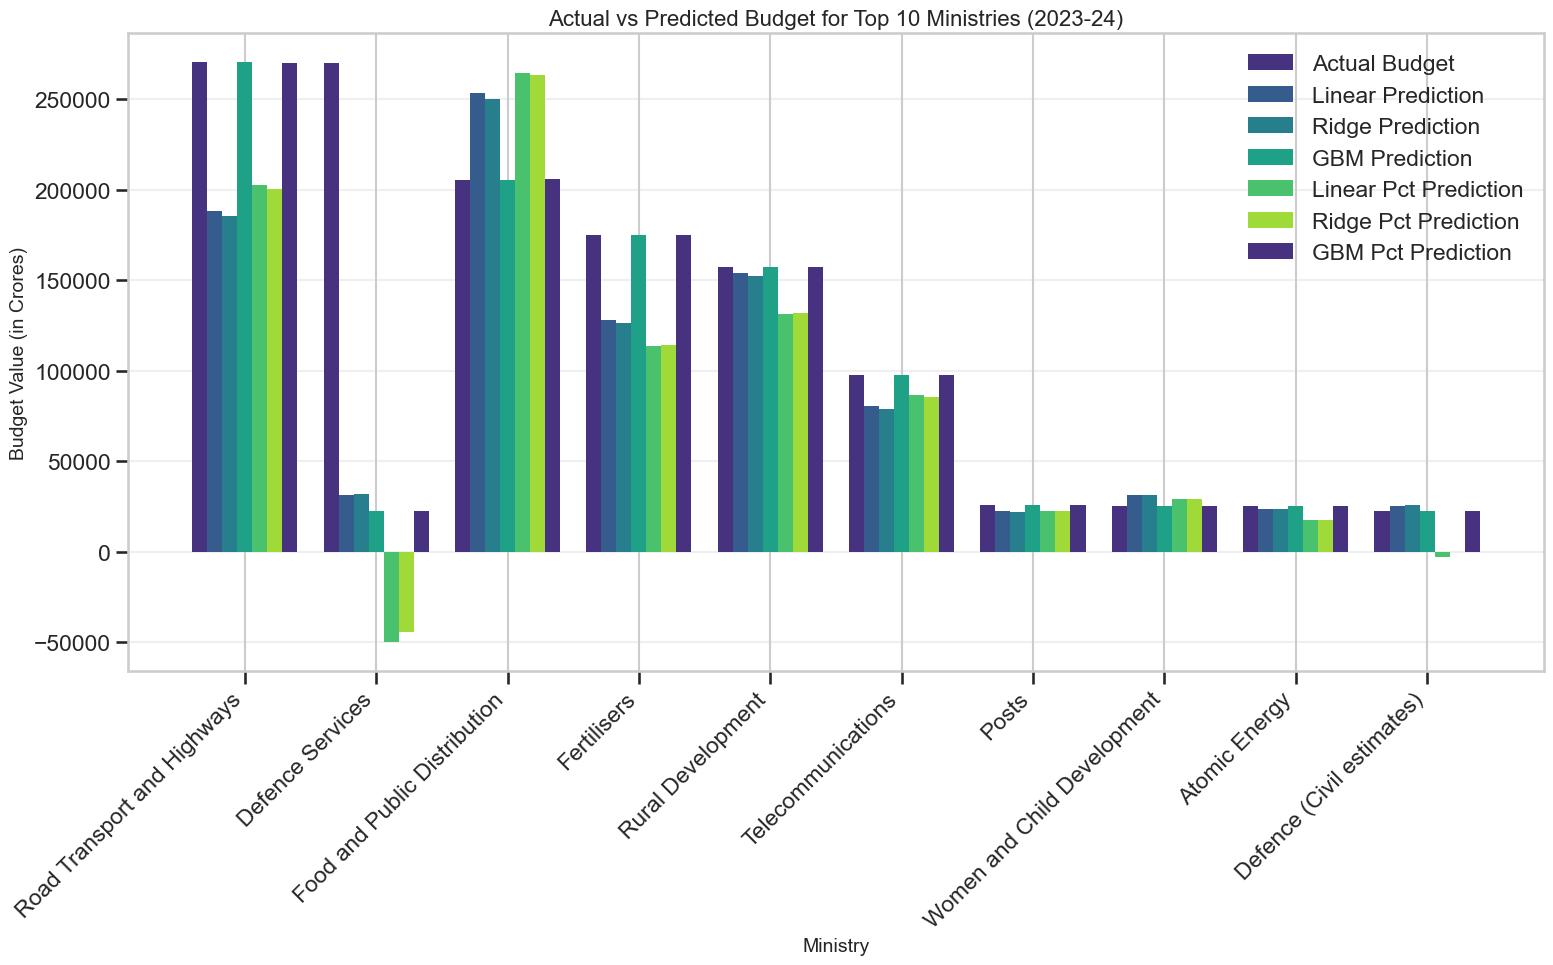


Predictions saved to: /Users/vvmohith/Desktop/PROJECT/ministry_budget_predictions.csv

Best performing model based on multiple metrics: GBM

Normalized Metrics and Composite Scores:
             R2_norm  MAE_norm  RMSE_norm  MAPE_norm  Composite_Score
Linear      0.806563  0.380703   0.779144   0.395867         0.590569
Ridge       0.814306  0.377141   0.787655   0.413874         0.598244
Lasso       0.806567  0.380706   0.779148   0.395656         0.590519
RF          0.929141  0.719603   0.917015   0.812496         0.844564
GBM         1.000000  1.000000   1.000000   1.000000         1.000000
Linear_Pct  0.000000  0.000000   0.000000   0.020727         0.005182
Ridge_Pct   0.064154  0.029436   0.055764   0.058279         0.051908
Lasso_Pct   0.245172  0.070086   0.218007   0.000000         0.133316
RF_Pct      0.924371  0.733200   0.911519   0.775455         0.836136
GBM_Pct     0.998431  0.997796   0.998134   0.997465         0.997956

Top 5 ministries with most accurate prediction

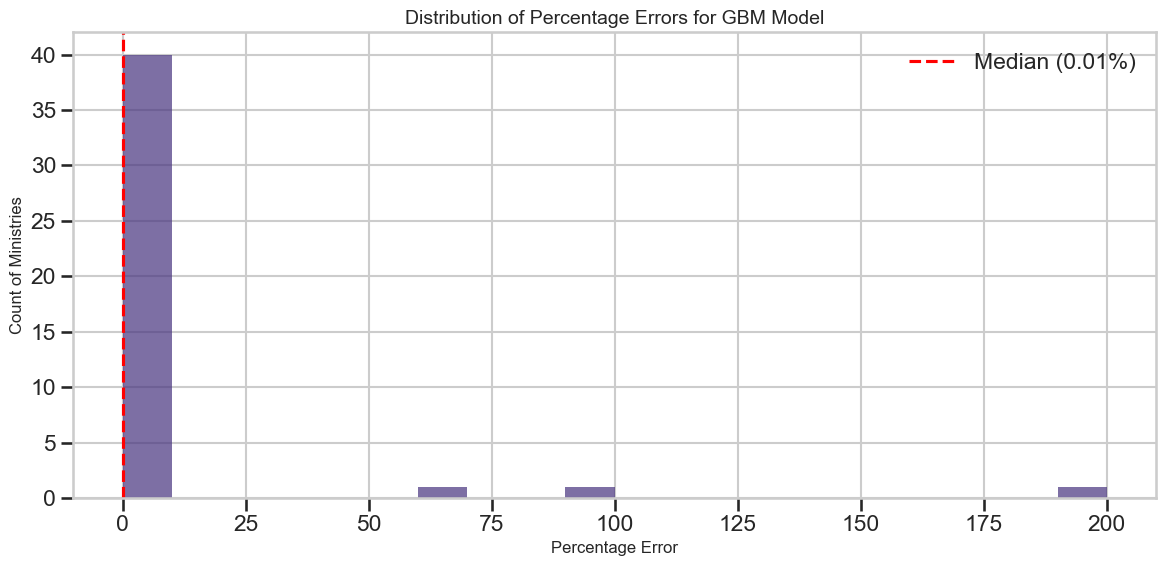

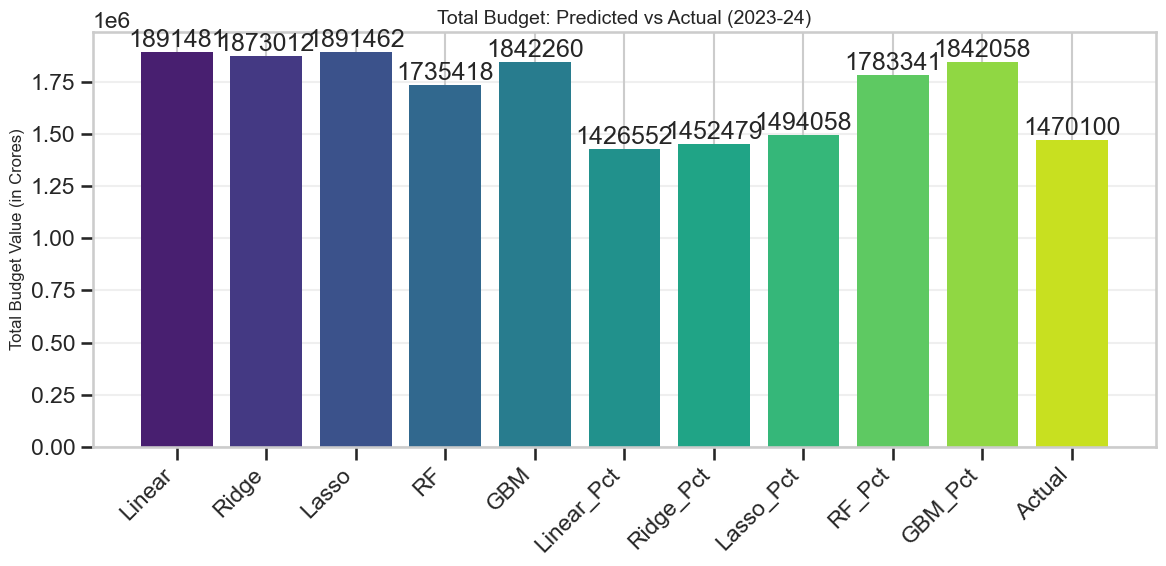


Summary of Budget Predictions for 2023-24
Total Actual Budget: 1470099.91 crores
Linear Model: 1891481.46 crores (Error: 28.66%)
Ridge Model: 1873012.29 crores (Error: 27.41%)
Lasso Model: 1891461.87 crores (Error: 28.66%)
RF Model: 1735418.14 crores (Error: 18.05%)
GBM Model: 1842259.95 crores (Error: 25.32%)
Linear_Pct Model: 1426552.41 crores (Error: 2.96%)
Ridge_Pct Model: 1452479.46 crores (Error: 1.20%)
Lasso_Pct Model: 1494058.14 crores (Error: 1.63%)
RF_Pct Model: 1783340.81 crores (Error: 21.31%)
GBM_Pct Model: 1842058.50 crores (Error: 25.30%)
Length mismatch: Years list (17) and importance list (1) have different lengths.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import re
import os

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
sns.set_context("talk")

# 1. Load the standardized data
time_series_data = pd.read_csv('/Users/vvmohith/Desktop/PROJECT/final_data/standardized_budget_time_series.csv')

# 2. Load actual 23-24 data for comparison
actual_data_23_24 = pd.read_csv('/Users/vvmohith/Desktop/PROJECT/dataset-final/23-24/23-24.csv')

# Clean up the actual data column names
actual_data_23_24.columns = [col.strip() for col in actual_data_23_24.columns]
ministry_col = actual_data_23_24.columns[0]  # Ministry name column
budget_col = actual_data_23_24.columns[1]    # Budget value column

# Ensure budget column is numeric
actual_data_23_24[budget_col] = pd.to_numeric(actual_data_23_24[budget_col], errors='coerce')

# 3. Load total budget data for each year to calculate percentage allocations
total_budgets = {}
dataset_path = '/Users/vvmohith/Desktop/PROJECT/dataset-final/'
for year_folder in sorted(os.listdir(dataset_path)):
    if not os.path.isdir(os.path.join(dataset_path, year_folder)):
        continue
        
    # Find CSV files in the folder
    csv_files = [f for f in os.listdir(os.path.join(dataset_path, year_folder)) if f.endswith('.csv')]
    
    # Try to find a file with total budget information
    for csv_file in csv_files:
        try:
            df = pd.read_csv(os.path.join(dataset_path, year_folder, csv_file))
            # Look for a grand total row
            for col in df.columns:
                if isinstance(df[col], pd.Series) and df[col].dtype == 'object':
                    grand_total_rows = df[df[col].str.contains('GRAND TOTAL', na=False, case=False, regex=True)]
                    if not grand_total_rows.empty:
                        # Extract the year from folder name
                        year_match = re.search(r'(\d{2})-(\d{2})', year_folder)
                        if year_match:
                            year = '20' + year_match.group(1) + '-' + year_match.group(2)
                            # Get the total budget value from the second column
                            try:
                                total_budgets[year] = float(grand_total_rows.iloc[0, 1])
                                break
                            except (ValueError, IndexError):
                                pass
        except Exception as e:
            print(f"Error reading {os.path.join(dataset_path, year_folder, csv_file)}: {e}")

print(f"Total budgets found for {len(total_budgets)} years")

# 4. Function to clean and standardize ministry names
def standardize_ministry_name(name):
    if pd.isna(name):
        return ""
    
    # Remove numbering and spaces
    name = str(name).lower().strip()
    name = re.sub(r'^\d+\.\s*', '', name)  # Remove leading numbers like "1. "
    name = name.replace("ministry of ", "").replace("department of ", "")
    name = name.replace("&", "and")
    name = name.replace("'s", "").replace("'", "")
    
    # Remove content in parentheses
    name = re.sub(r'\(.*?\)', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    
    return name

# 5. Clean ministry names in actual data
actual_data_23_24['Standardized_Ministry'] = actual_data_23_24[ministry_col].apply(standardize_ministry_name)

# 6. Validate and clean numeric columns
def validate_numeric_columns(df, columns):
    """Check if all values in the specified columns are numeric"""
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# 7. Add percentage allocation features to time series data
year_columns = [col for col in time_series_data.columns if col != 'Base_Ministry']
time_series_data = validate_numeric_columns(time_series_data, year_columns)

# Create percentage features
pct_columns = []
for year_col in year_columns:
    # Map year_col format (e.g., '05-06') to total_budgets format (e.g., '2005-06')
    year_key = '20' + year_col if year_col in ['05-06', '06-07', '07-08', '08-09', '09-10'] else '20' + year_col
    
    if year_key in total_budgets and total_budgets[year_key] > 0:
        pct_col = f'{year_col}_pct'
        time_series_data[pct_col] = time_series_data[year_col] / total_budgets[year_key] * 100
        pct_columns.append(pct_col)
        print(f"Added percentage column {pct_col}")

# 8. Define enhanced prediction function
def predict_ministry_budget(ministry_data, years, pct_years=None, total_budget_23_24=None, target_year="2023"):
    """
    Build models to predict budget for a ministry for the target year
    
    Parameters:
    -----------
    ministry_data : pandas Series
        Time series data for a single ministry
    years : list
        List of years as strings
    pct_years : list
        List of percentage allocation years
    total_budget_23_24 : float
        Total budget for 23-24 to convert percentage predictions
    target_year : str
        Year to predict
        
    Returns:
    --------
    dict with predictions from different models
    """
    # Match columns to fiscal years (05-06 through 23-24)
    numeric_years = []
    
    for year_col in years:
        # Since column names are fiscal years (05-06, 06-07, etc.)
        year_val = 2005 + years.index(year_col)
        numeric_years.append(year_val)
    
    numeric_years = np.array(numeric_years).reshape(-1, 1)
    
    # Get budget values and convert to numeric
    budget_values = []
    for year in years:
        try:
            value = pd.to_numeric(ministry_data[year], errors='coerce')
            budget_values.append(value)
        except (ValueError, TypeError):
            budget_values.append(np.nan)
    
    y = np.array(budget_values)
    
    # Filter out NaN values (years without data)
    mask = ~np.isnan(y)
    X = numeric_years[mask]
    y = y[mask]
    
    # Get percentage allocations if available
    if pct_years and total_budget_23_24:
        pct_values = []
        for pct_year in pct_years:
            try:
                value = pd.to_numeric(ministry_data[pct_year], errors='coerce')
                pct_values.append(value)
            except (ValueError, TypeError):
                pct_values.append(np.nan)
        
        y_pct = np.array(pct_values)
        mask_pct = ~np.isnan(y_pct)
        X_pct = np.array([2005 + pct_years.index(year) for year in pct_years]).reshape(-1, 1)[mask_pct]
        y_pct = y_pct[mask_pct]
    
    if len(y) < 3:  # Not enough data points
        return {'linear': None, 'ridge': None, 'lasso': None, 'rf': None, 'gbm': None}
    
    # Initialize models
    models = {
        'linear': LinearRegression(),
        'ridge': Ridge(alpha=10.0),
        'lasso': Lasso(alpha=1.0),
        'rf': RandomForestRegressor(n_estimators=100, random_state=42),
        'gbm': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    # For percentage prediction models
    pct_models = {
        'linear_pct': LinearRegression(),
        'ridge_pct': Ridge(alpha=10.0),
        'lasso_pct': Lasso(alpha=1.0),
        'rf_pct': RandomForestRegressor(n_estimators=100, random_state=42),
        'gbm_pct': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    predictions = {}
    
    # Target year to predict
    target_X = np.array([[int(target_year)]])
    
    # Train absolute value models and make predictions
    for name, model in models.items():
        try:
            model.fit(X, y)
            predictions[name] = float(model.predict(target_X)[0])
        except Exception as e:
            print(f"Error with {name} model for {ministry_data['Base_Ministry']}: {str(e)}")
            predictions[name] = None
    
    # Train percentage models and make predictions
    if pct_years and total_budget_23_24 and len(y_pct) >= 3:
        for name, model in pct_models.items():
            try:
                model.fit(X_pct, y_pct)
                pct_prediction = model.predict(target_X)[0]
                # Convert percentage to absolute value
                abs_prediction = pct_prediction * total_budget_23_24 / 100
                predictions[name] = float(abs_prediction)
            except Exception as e:
                print(f"Error with {name} model for {ministry_data['Base_Ministry']}: {str(e)}")
                predictions[name] = None
    
    return predictions

# 9. Get total budget for 23-24
try:
    total_budget_23_24 = float(actual_data_23_24[actual_data_23_24[ministry_col].str.contains('GRAND TOTAL', case=False)][budget_col].values[0])
    print(f"Total budget for 23-24: {total_budget_23_24}")
except (IndexError, ValueError):
    total_budget_23_24 = None
    print("Warning: Could not find total budget for 23-24")

# 10. Make predictions for each ministry
results = []

for idx, row in time_series_data.iterrows():
    ministry = row['Base_Ministry']
    
    # Predict budget using different models
    predictions = predict_ministry_budget(
        row, 
        year_columns, 
        pct_years=pct_columns if pct_columns else None,
        total_budget_23_24=total_budget_23_24,
        target_year="2023"
    )
    
    # Find actual budget from 23-24 data
    actual_match = actual_data_23_24[actual_data_23_24['Standardized_Ministry'] == standardize_ministry_name(ministry)]
    
    if not actual_match.empty:
        actual_budget = float(actual_match.iloc[0][budget_col])
    else:
        actual_budget = None
    
    # Store results
    result_dict = {
        'Ministry': ministry,
        'Standardized_Ministry': standardize_ministry_name(ministry),
        'Linear_Prediction': predictions['linear'],
        'Ridge_Prediction': predictions['ridge'],
        'Lasso_Prediction': predictions['lasso'],
        'RF_Prediction': predictions['rf'],
        'GBM_Prediction': predictions['gbm'],
        'Actual_Budget': actual_budget
    }
    
    # Add percentage-based predictions if available
    if pct_columns and total_budget_23_24:
        result_dict.update({
            'Linear_Pct_Prediction': predictions.get('linear_pct'),
            'Ridge_Pct_Prediction': predictions.get('ridge_pct'),
            'Lasso_Pct_Prediction': predictions.get('lasso_pct'),
            'RF_Pct_Prediction': predictions.get('rf_pct'),
            'GBM_Pct_Prediction': predictions.get('gbm_pct')
        })
    
    results.append(result_dict)

# 11. Convert results to DataFrame
results_df = pd.DataFrame(results)

# 12. Calculate error metrics for each model where actuals are available
def calculate_errors(df, include_pct_models=False):
    metrics = {}
    models = ['Linear', 'Ridge', 'Lasso', 'RF', 'GBM']
    
    if include_pct_models:
        models += ['Linear_Pct', 'Ridge_Pct', 'Lasso_Pct', 'RF_Pct', 'GBM_Pct']
    
    for model in models:
        pred_col = f'{model}_Prediction'
        if pred_col not in df.columns:
            continue
            
        # Filter rows where both prediction and actual are available
        valid_data = df.dropna(subset=[pred_col, 'Actual_Budget'])
        
        if len(valid_data) > 0:
            # Convert to numeric to ensure we don't have string values
            y_true = pd.to_numeric(valid_data['Actual_Budget'], errors='coerce')
            y_pred = pd.to_numeric(valid_data[pred_col], errors='coerce')
            
            # Drop any rows that couldn't be converted to numbers
            valid_mask = ~(np.isnan(y_true) | np.isnan(y_pred))
            y_true = y_true[valid_mask]
            y_pred = y_pred[valid_mask]
            
            if len(y_true) > 0:  # Only calculate if we have valid data
                mae = mean_absolute_error(y_true, y_pred)
                rmse = np.sqrt(mean_squared_error(y_true, y_pred))
                r2 = r2_score(y_true, y_pred)
                # Avoid division by zero
                mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100
                
                metrics[model] = {
                    'MAE': mae,
                    'RMSE': rmse,
                    'R2': r2,
                    'MAPE': mape,
                    'Count': len(y_true)
                }
    
    return metrics

# Calculate error metrics
errors = calculate_errors(results_df, include_pct_models=(len(pct_columns) > 0))

# 13. Fixed visualization function
def plot_predictions_vs_actual(df, top_n=10, include_pct_models=False):
    # Ensure all numeric columns are properly converted
    budget_cols = ['Actual_Budget']
    model_cols = ['Linear_Prediction', 'Ridge_Prediction', 'GBM_Prediction']
    
    if include_pct_models:
        model_cols += ['Linear_Pct_Prediction', 'Ridge_Pct_Prediction', 'GBM_Pct_Prediction']
    
    # Ensure all columns exist
    model_cols = [col for col in model_cols if col in df.columns]
    all_cols = budget_cols + model_cols
    
    # Convert all numeric columns to float
    for col in all_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Sort by actual budget (descending) and take top N
    df_plot = df.copy()
    df_plot = df_plot.dropna(subset=['Actual_Budget']).sort_values('Actual_Budget', ascending=False).head(top_n)
    
    # Ensure we have data to plot
    if len(df_plot) == 0:
        print("No valid data to plot.")
        return
    
    # Select models to include
    model_cols = ['Actual_Budget'] + [col for col in model_cols if col in df_plot.columns]
    
    # Convert Ministry to string to avoid type errors
    df_plot['Ministry'] = df_plot['Ministry'].astype(str)
    
    # Create a plot with Matplotlib directly instead of seaborn
    plt.figure(figsize=(16, 10))
    
    # Set up barplot parameters
    n_models = len(model_cols)
    width = 0.8 / n_models  # Bar width
    x = np.arange(len(df_plot))  # X positions for ministries
    
    # Plot each model's predictions
    for i, model in enumerate(model_cols):
        values = df_plot[model].values
        offset = width * (i - n_models/2 + 0.5)
        plt.bar(x + offset, values, width=width, label=model.replace('_', ' '))
    
    # Formatting
    plt.title(f'Actual vs Predicted Budget for Top {top_n} Ministries (2023-24)', fontsize=16)
    plt.ylabel('Budget Value (in Crores)', fontsize=14)
    plt.xlabel('Ministry', fontsize=14)
    plt.xticks(x, df_plot['Ministry'], rotation=45, ha='right')
    plt.legend(title='')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Save figure
    plt.savefig('/Users/vvmohith/Desktop/PROJECT/predictions_vs_actual.png', dpi=300)
    plt.show()

# 14. Display error metrics in a table
error_df = pd.DataFrame({model: metrics for model, metrics in errors.items()}).T
print("\nModel Performance Metrics:")
print(error_df)

# 15. Plot predictions vs actual for top ministries
plot_predictions_vs_actual(results_df, include_pct_models=(len(pct_columns) > 0))

# 16. Save the results
results_df.to_csv('/Users/vvmohith/Desktop/PROJECT/ministry_budget_predictions.csv', index=False)
print(f"\nPredictions saved to: /Users/vvmohith/Desktop/PROJECT/ministry_budget_predictions.csv")

# 17. Find best performing model based on multiple metrics
def get_best_model(error_df):
    # Normalize metrics
    normalized_metrics = pd.DataFrame()
    
    # For R2, higher is better, for others lower is better
    normalized_metrics['R2_norm'] = (error_df['R2'] - error_df['R2'].min()) / (error_df['R2'].max() - error_df['R2'].min())
    normalized_metrics['MAE_norm'] = 1 - (error_df['MAE'] - error_df['MAE'].min()) / (error_df['MAE'].max() - error_df['MAE'].min())
    normalized_metrics['RMSE_norm'] = 1 - (error_df['RMSE'] - error_df['RMSE'].min()) / (error_df['RMSE'].max() - error_df['RMSE'].min())
    normalized_metrics['MAPE_norm'] = 1 - (error_df['MAPE'] - error_df['MAPE'].min()) / (error_df['MAPE'].max() - error_df['MAPE'].min())
    
    # Calculate a composite score (average of all normalized metrics)
    normalized_metrics['Composite_Score'] = normalized_metrics.mean(axis=1)
    
    # Get the model with the highest composite score
    best_model = normalized_metrics['Composite_Score'].idxmax()
    
    return best_model, normalized_metrics

# Get the best model based on multiple metrics
best_model, normalized_metrics = get_best_model(error_df)
print(f"\nBest performing model based on multiple metrics: {best_model}")
print("\nNormalized Metrics and Composite Scores:")
print(normalized_metrics)

# 18. Calculate percentage errors for the best model
best_pred_col = f'{best_model}_Prediction'
results_df['Percentage_Error'] = np.abs(
    pd.to_numeric(results_df[best_pred_col], errors='coerce') - 
    pd.to_numeric(results_df['Actual_Budget'], errors='coerce')
) / np.maximum(np.abs(pd.to_numeric(results_df['Actual_Budget'], errors='coerce')), 1e-10) * 100

# Sort by percentage error
results_df_with_error = results_df.dropna(subset=['Percentage_Error']).sort_values('Percentage_Error')

# Display ministries with lowest and highest error
print("\nTop 5 ministries with most accurate predictions:")
print(results_df_with_error[['Ministry', best_pred_col, 'Actual_Budget', 'Percentage_Error']].head(5))

print("\nTop 5 ministries with least accurate predictions:")
print(results_df_with_error[['Ministry', best_pred_col, 'Actual_Budget', 'Percentage_Error']].tail(5))

# 19. Plot error distribution
plt.figure(figsize=(12, 6))
plt.hist(results_df_with_error['Percentage_Error'].clip(upper=200), bins=20, alpha=0.7)  # Clip to avoid extreme outliers
plt.axvline(results_df_with_error['Percentage_Error'].median(), color='red', linestyle='--', 
           label=f'Median ({results_df_with_error["Percentage_Error"].median():.2f}%)')
plt.title(f'Distribution of Percentage Errors for {best_model} Model', fontsize=14)
plt.xlabel('Percentage Error', fontsize=12)
plt.ylabel('Count of Ministries', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('/Users/vvmohith/Desktop/PROJECT/error_distribution.png', dpi=300)
plt.show()

# 20. Plot a comparison of total budget - Fixed version
# Calculate total predicted vs actual budget
results_df['Actual_Budget'] = pd.to_numeric(results_df['Actual_Budget'], errors='coerce')
total_actual = results_df['Actual_Budget'].sum()

model_columns = [col for col in results_df.columns if col.endswith('_Prediction')]
total_predictions = {}
for model in model_columns:
    results_df[model] = pd.to_numeric(results_df[model], errors='coerce')
    total_predictions[model.replace('_Prediction', '')] = results_df[model].sum()

# Create a bar chart comparing totals using matplotlib
plt.figure(figsize=(12, 6))
models_list = list(total_predictions.keys())
values_list = list(total_predictions.values())
x_pos = np.arange(len(models_list) + 1)
bars = plt.bar(x_pos, values_list + [total_actual], 
          color=sns.color_palette("viridis", len(models_list) + 1))

plt.title('Total Budget: Predicted vs Actual (2023-24)', fontsize=14)
plt.ylabel('Total Budget Value (in Crores)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(x_pos, models_list + ['Actual'], rotation=45, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}',
            ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('/Users/vvmohith/Desktop/PROJECT/total_budget_comparison.png', dpi=300)
plt.show()

# 21. Summary of prediction performance
print("\nSummary of Budget Predictions for 2023-24")
print(f"Total Actual Budget: {total_actual:.2f} crores")
for model, pred in total_predictions.items():
    error = abs(pred - total_actual) / total_actual * 100
    print(f"{model} Model: {pred:.2f} crores (Error: {error:.2f}%)")

# 22. Feature importance for best model (if it's RF or GBM) - Fixed version
if best_model in ['RF', 'GBM']:
    model_name = 'Random Forest' if best_model == 'RF' else 'Gradient Boosting'
    
    # Create a feature importance analysis for a sample ministry
    # Choose a ministry with good prediction
    if len(results_df_with_error) > 0:
        sample_ministry = results_df_with_error.iloc[0]['Ministry']
        sample_row = time_series_data[time_series_data['Base_Ministry'] == sample_ministry]
        
        if not sample_row.empty:
            sample_row = sample_row.iloc[0]
            
            # Get years with data
            valid_years = [year for year in year_columns if pd.notna(sample_row[year])]
            
            if len(valid_years) >= 3:  # Need at least 3 data points
                X_years = np.array([2005 + year_columns.index(year) for year in valid_years]).reshape(-1, 1)
                y_budgets = np.array([float(sample_row[year]) for year in valid_years])
                
                # Verify that X_years and y_budgets have the same length
                if len(X_years) == len(y_budgets):
                    # Train the model
                    model = RandomForestRegressor(n_estimators=100, random_state=42) if best_model == 'RF' else GradientBoostingRegressor(n_estimators=100, random_state=42)
                    model.fit(X_years, y_budgets)
                    
                    # Create and verify the feature importance data
                    years_list = [str(2005 + year_columns.index(year)) for year in valid_years]
                    importance_list = model.feature_importances_
                    
                    # Double-check that both arrays have the same length
                    if len(years_list) == len(importance_list):
                        # Plot feature importance
                        plt.figure(figsize=(10, 6))
                        
                        # Create DataFrame safely
                        feature_importance = pd.DataFrame({
                            'Year': years_list,
                            'Importance': importance_list
                        })
                        
                        plt.bar(feature_importance['Year'], feature_importance['Importance'])
                        plt.title(f'{model_name} Feature Importance for {sample_ministry}', fontsize=14)
                        plt.xlabel('Year', fontsize=12)
                        plt.ylabel('Importance', fontsize=12)
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        plt.savefig('/Users/vvmohith/Desktop/PROJECT/feature_importance.png', dpi=300)
                        plt.show()
                    else:
                        print(f"Length mismatch: Years list ({len(years_list)}) and importance list ({len(importance_list)}) have different lengths.")
                else:
                    print(f"Length mismatch: X_years ({len(X_years)}) and y_budgets ({len(y_budgets)}) have different lengths.")
            else:
                print(f"Not enough data points for {sample_ministry}: only {len(valid_years)} valid years found.")
        else:
            print(f"Could not find data for {sample_ministry} in the time series dataset.")
    else:
        print("No ministries with error data available for feature importance analysis.")